# Preprocessing

In [1]:
from read_corpus import *
import pandas as pd

utterances = read_corpus('bm_tagged_w_ner')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:19<00:00,  2.82it/s]


In [2]:
# Filter only CS utterances
cs_uters = []
for uter in utterances:
    lngs = set()
    for token in uter.tokens:
        if token.lang.startswith('shared'):
            continue
        lngs.add(token.lang)
    if len(lngs) > 1:
        cs_uters.append(uter)
print(len(cs_uters))
print(len(utterances))

# cs_uters = utterances

2799
42910


In [3]:
def print_uter(uter):
    print(uter.filename)
    print(uter.uter_id)
    print(str(uter))
    tuples = []
    for t in uter.tokens:
        tuples.append((t.surface, t.lang, t.postag, t.bin_cognate))
    print(tuples)
    
print_uter(cs_uters[0])

herring1.csv
67
and your grandmother was like oh todo se mira en las manos
[('and', 'eng', 'CONJ', 0), ('your', 'eng', 'DET', 0), ('grandmother', 'eng', 'NOUN', 0), ('was', 'eng', 'VERB', 0), ('like', 'eng', 'ADV', 0), ('oh', 'shared_other', 'INTJ', 0), ('todo', 'spa', 'PRON', 0), ('se', 'spa', 'PRON', 0), ('mira', 'spa', 'VERB', 0), ('en', 'spa', 'ADP', 1), ('las', 'spa', 'DET', 0), ('manos', 'spa', 'NOUN', 0)]


In [4]:
# Factorize // 0 value means missing (in vectors of size < K)
pos_tags_map_name = {}
pos_tags_map_value = {}
pos_tags_map_value[0] = 'NONE'
pos_tags_map_name['NONE']=0

pos_tags_set = set()
for uter in cs_uters:
    for token in uter.tokens:
        pos_tags_set.add(token.postag)
        
for i, pt in enumerate(pos_tags_set):
    pos_tags_map_value[i+1] = pt
    pos_tags_map_name[pt] = i+1

print(pos_tags_map_name)
print(pos_tags_map_value)

{'NONE': 0, 'PART': 1, 'NUM': 2, 'CONJ': 3, 'ADV': 4, 'ADP': 5, 'INTJ': 6, 'ADJ': 7, 'PROPN': 8, 'X': 9, 'AUX': 10, 'PRON': 11, 'SCONJ': 12, 'DET': 13, 'NOUN': 14, 'VERB': 15}
{0: 'NONE', 1: 'PART', 2: 'NUM', 3: 'CONJ', 4: 'ADV', 5: 'ADP', 6: 'INTJ', 7: 'ADJ', 8: 'PROPN', 9: 'X', 10: 'AUX', 11: 'PRON', 12: 'SCONJ', 13: 'DET', 14: 'NOUN', 15: 'VERB'}


In [5]:
from tqdm import tqdm

k=5   # context / window size
min=2 # keep the starting vectors of each uter

def vectors_in_window(arr):
    result = [arr[0:min+i] for i in range(k-min)]
    result.extend([arr[i:i+k] for i in range(len(arr)-k+1)])
    return result

def is_cs(lng_vec):
    curr = lng_vec[-1]
    prev = lng_vec[-2]
    
    if curr == 'eng' and prev == 'spa':
        return 1
    if curr == 'spa' and prev == 'eng':
        return 1
    
    # check shared other
    if prev == "shared_other" and len(lng_vec) > 2:
        prev_prev = lng_vec[-3]
        return 1 if prev_prev != prev != curr else 0
    
    return 0


def vectorize(uter, debug=False):
    raw = vectors_in_window(uter.tokens)
    df = pd.DataFrame()
    for vec_idx, v in enumerate(raw):
        vec_key = f'{uter.filename}_{uter.uter_id}_{vec_idx}'
        
        pos3_1hot = {pos_tags_map_value[i]:0 for i in pos_tags_map_value}
        pos4_1hot = {pos_tags_map_value[i]:0 for i in pos_tags_map_value}
        
        pos_tag_vec = []
        lng_vec = []
        text_vec = []

        for t in v:
            pos_tag_vec.append(t.postag)
            text_vec.append(t.surface)
            lng_vec.append(t.lang)
            if debug: print((t.surface, t.lang, t.postag))
        
        sub_uter = ' '.join(text_vec)
        label = is_cs(lng_vec)
        
        # fix short vectors to K
        for _ in range(k-len(v)):
            pos_tag_vec.insert(0, 0)
        
        pos3_1hot[pos_tag_vec[3]] += 1
        pos4_1hot[pos_tag_vec[4]] += 1

        # convert to pandas
        data = {}
        data.update({f'postag3_{i}':pos3_1hot[i] for i in pos3_1hot})
        data.update({f'postag4_{i}':pos4_1hot[i] for i in pos3_1hot})
        data.update({'label': label, 'sub_uter':sub_uter ,'full_uter': str(uter), 'key': vec_key})
        tmp_df = pd.DataFrame(data, index=[0])
        df = pd.concat([df, tmp_df])
        
        if debug:
            print(sub_uter)
            print('lng:', lng_vec)
            print('postag vec:', pos_tag_vec)
            print('label:', label)
            print()
    return df


# vectorize(cs_uters[0], True)
df = pd.DataFrame()
for uter in tqdm(cs_uters):
    df = pd.concat([df, vectorize(uter)])
# df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2799/2799 [00:18<00:00, 151.83it/s]


In [6]:
vectorize(cs_uters[0], True)

('and', 'eng', 'CONJ')
('your', 'eng', 'DET')
and your
lng: ['eng', 'eng']
postag vec: [0, 0, 0, 'CONJ', 'DET']
label: 0

('and', 'eng', 'CONJ')
('your', 'eng', 'DET')
('grandmother', 'eng', 'NOUN')
and your grandmother
lng: ['eng', 'eng', 'eng']
postag vec: [0, 0, 'CONJ', 'DET', 'NOUN']
label: 0

('and', 'eng', 'CONJ')
('your', 'eng', 'DET')
('grandmother', 'eng', 'NOUN')
('was', 'eng', 'VERB')
and your grandmother was
lng: ['eng', 'eng', 'eng', 'eng']
postag vec: [0, 'CONJ', 'DET', 'NOUN', 'VERB']
label: 0

('and', 'eng', 'CONJ')
('your', 'eng', 'DET')
('grandmother', 'eng', 'NOUN')
('was', 'eng', 'VERB')
('like', 'eng', 'ADV')
and your grandmother was like
lng: ['eng', 'eng', 'eng', 'eng', 'eng']
postag vec: ['CONJ', 'DET', 'NOUN', 'VERB', 'ADV']
label: 0

('your', 'eng', 'DET')
('grandmother', 'eng', 'NOUN')
('was', 'eng', 'VERB')
('like', 'eng', 'ADV')
('oh', 'shared_other', 'INTJ')
your grandmother was like oh
lng: ['eng', 'eng', 'eng', 'eng', 'shared_other']
postag vec: ['DET', 

,postag3_NONE,postag3_PART,postag3_NUM,postag3_CONJ,postag3_ADV,postag3_ADP,postag3_INTJ,postag3_ADJ,postag3_PROPN,postag3_X,...,postag4_AUX,postag4_PRON,postag4_SCONJ,postag4_DET,postag4_NOUN,postag4_VERB,label,sub_uter,full_uter,key
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,and your,and your grandmother was like oh todo se mira ...,herring1.csv_67_0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,and your grandmother,and your grandmother was like oh todo se mira ...,herring1.csv_67_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,and your grandmother was,and your grandmother was like oh todo se mira ...,herring1.csv_67_2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,and your grandmother was like,and your grandmother was like oh todo se mira ...,herring1.csv_67_3
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,your grandmother was like oh,and your grandmother was like oh todo se mira ...,herring1.csv_67_4
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,grandmother was like oh todo,and your grandmother was like oh todo se mira ...,herring1.csv_67_5
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,was like oh todo se,and your grandmother was like oh todo se mira ...,herring1.csv_67_6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,like oh todo se mira,and your grandmother was like oh todo se mira ...,herring1.csv_67_7
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,oh todo se mira en,and your grandmother was like oh todo se mira ...,herring1.csv_67_8
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,todo se mira en las,and your grandmother was like oh todo se mira ...,herring1.csv_67_9


# CLS

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
from sklearn import tree
import plotly.express as px
import plotly.graph_objects as go

In [8]:
# balance the data:
balance = False
print('all:', len(df))

if balance:
    pos_df = (df[df['label'] == 1])
    neg_df = (df[df['label'] == 0])
    print('label1:', len(pos_df))
    print('label0:', len(neg_df))
    print('down sampling:')


    neg_df = resample(neg_df,
                      replace=True,     # sample with replacement
                      n_samples=len(pos_df),    # to match majority class
                      random_state=42) # reproducible results

    print('label0:', len(neg_df))
    bdf = pd.concat([pos_df, neg_df])
    print('all:', len(bdf))
    # bdf.to_csv('balanced_cls_df.csv')
else:
    bdf = df.copy()
    

# remove unused cols
bdf_copy = bdf.copy()
labels = bdf['label']
bdf.drop(['label', 'sub_uter', 'full_uter', 'key'], axis=1, inplace=True)
print(labels.value_counts())

neg = labels.value_counts().tolist()[0]
pos = labels.value_counts().tolist()[1]
majority_cls_acc = neg/(pos+neg)
print('majority_cls_acc: ', majority_cls_acc)


def remove_feature(feature_prefix):
    features = [f'{feature_prefix}_{i}' for i in range(len(pos_tags_map_value))]
    bdf.drop(features, axis=1, inplace=True)

# remove_feature('postag4')
# remove_feature('postag3')

bdf.head()

all: 28059
0    23900
1     4159
Name: label, dtype: int64
majority_cls_acc:  0.8517766135642753


,postag3_NONE,postag3_PART,postag3_NUM,postag3_CONJ,postag3_ADV,postag3_ADP,postag3_INTJ,postag3_ADJ,postag3_PROPN,postag3_X,...,postag4_INTJ,postag4_ADJ,postag4_PROPN,postag4_X,postag4_AUX,postag4_PRON,postag4_SCONJ,postag4_DET,postag4_NOUN,postag4_VERB
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
md = 17

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf = RandomForestClassifier(criterion='entropy', max_depth=md)
cv_scores = cross_val_score(clf, bdf, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.65384615 0.65985577 0.66466346 0.671875   0.65264423 0.66586538
 0.68629808 0.66706731 0.68953069 0.68351384]
0.6695159909284458


In [10]:
# scores = []
# for md in tqdm([3,5,7,9,11,13,15,17,19]):
#     clf = RandomForestClassifier(criterion='entropy', max_depth=md)
#     cv_scores = cross_val_score(clf, bdf, labels, cv=10)
#     scores.append(np.mean(cv_scores))
# plt.plot(scores)
# print('idx:', np.argmax(scores), 'val:', np.max(scores))

In [9]:
def rename_features(names: list[str]):
    rename = []
    for n in names:
        pos_tag_value = n.split('_')[1]
        pos_tag = n.split('_')[0]
        pos_tag_name = pos_tags_map_value[int(pos_tag_value)]
        rename.append(f'{pos_tag}_{pos_tag_name}')
    return rename

def plot_importance(feature_imp_):
    feature_imp_ = feature_imp_[0:10]
    y=feature_imp_.index
#     y = rename_features(list(y))
    sns.barplot(x=feature_imp_, y=y)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    plt.show()
    

def pos_tag_map_for_plot(df_, feature):
    tags = list(df_[feature])
    tags_names = [pos_tags_map_value[tag] for tag in tags]
    df_[feature] = tags_names

    
def scatter_imp_features(feature_imp_, i0=0, i1=1):
    def plot_2_features_heatmap(x,y,feature0,feature1, title, z):
        fig = px.imshow(z, labels=dict(x=feature0, y=feature1, color="count"),x=x,y=y)
        fig.update_layout(title=title)
        fig.show()

    feature0 = feature_imp_.keys()[i0]
    feature1 = feature_imp_.keys()[i1]

    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)

    table_x_max = max(list(df_[feature0].value_counts().keys())) + 1
    table_y_max = max(list(df_[feature1].value_counts().keys())) + 1
    pos_counts = np.zeros([table_y_max,table_x_max])
    neg_counts = np.zeros([table_y_max,table_x_max])

    for _, row in df_.iterrows():
        if row['label'] == '1':
            pos_counts[row[feature1]][row[feature0]] += 1
        else:
            neg_counts[row[feature1]][row[feature0]] += 1

    x=np.arange(table_x_max)
    y=np.arange(table_y_max)

    if feature0.startswith('postag'):
        x = list(pos_tags_map_value.values())
    if feature1.startswith('postag'):
        y = list(pos_tags_map_value.values())  


    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 0: {feature0} vs {feature1}",
                            z=neg_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 1: {feature0} vs {feature1}",
                            z=pos_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"label 1 > label 0: {feature0} vs {feature1}",
                            z=(pos_counts>neg_counts).astype(int))


def hist_imp_features(feature_imp_, i1=0):
    feature = feature_imp_.keys()[i1]
    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)
    
    if feature.startswith('postag'):
        pos_tag_map_for_plot(df_, feature)

    pos_df = (df_[df_['label'] == '1'])
    neg_df = (df_[df_['label'] == '0'])
    
    pos_values = pos_df[feature].value_counts()
    neg_values = neg_df[feature].value_counts()

    fig = go.Figure(data=[
        go.Bar(name='1', x=list(pos_values.keys()), y=pos_values.tolist()),
        go.Bar(name='0', x=list(neg_values.keys()), y=neg_values.tolist()),
    ])

    fig.update_layout(
        title=f"{feature} ordered histogram",
        xaxis_title=feature,
        yaxis_title="count",
        legend_title="CS label",
    )
    fig.update_xaxes(categoryorder='total ascending')

    fig.show()


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      7170
           1       0.68      0.02      0.03      1248

    accuracy                           0.85      8418
   macro avg       0.77      0.51      0.48      8418
weighted avg       0.83      0.85      0.79      8418

max_depth: 17


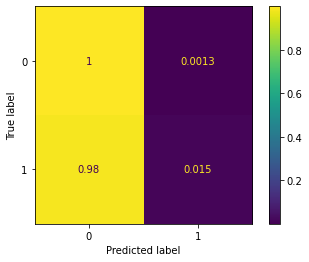

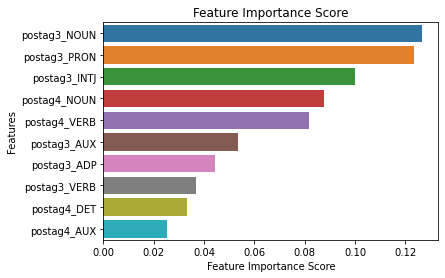

In [12]:
X_train, X_test, y_train, y_test = train_test_split(bdf, labels, random_state=0, test_size=0.3, stratify=labels)

xtrain = X_train
xtest = X_test

clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(xtrain, y_train)
feature_imp_ = pd.Series(clf.feature_importances_,index=bdf.columns.tolist()).sort_values(ascending=False)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))


cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
print('max_depth:', md)

plot_importance(feature_imp_)
# hist_imp_features(feature_imp_,0)
# hist_imp_features(feature_imp_,1)
# hist_imp_features(feature_imp_,2)
# scatter_imp_features(feature_imp_)


In [13]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(chi2, k = 20)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(bdf, labels)
names = bdf.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

       Feat_names    F_Scores
8    postag3_NOUN  450.287450
4    postag3_INTJ  416.948377
1    postag3_PRON  410.238629
15   postag4_VERB  293.505984
19   postag4_NOUN  289.715301
7     postag3_AUX  136.027964
5     postag3_ADP   97.814225
12    postag4_ADJ   73.237392
14   postag4_CONJ   71.226388
11    postag4_DET   65.290185
18    postag4_AUX   64.518413
17   postag4_PART   59.667176
10   postag4_PRON   52.862866
2     postag3_DET   51.506266
6    postag3_PART   47.464450
0   postag3_PROPN   31.753267
3     postag3_ADJ   23.471252
16  postag4_SCONJ   21.122998
9   postag4_PROPN   20.115413
13   postag4_INTJ   18.935143


Data

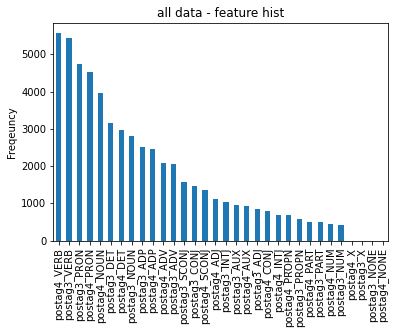

In [13]:
def plot_hist(df_, title):
    s = df_.sum()
    s = s.sort_values(ascending=False)
    features = s.index.tolist()
    ax = s.plot.bar(title=title)
    ax.set_ylabel("Freqeuncy")

plot_hist(bdf, 'all data - feature hist')

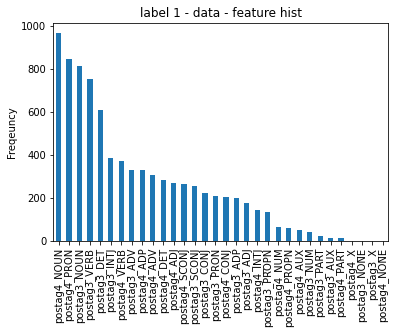

In [27]:
pos_df = (bdf_copy[bdf_copy['label'] == 1]).copy()
neg_df = (bdf_copy[bdf_copy['label'] == 0]).copy()

pos_df.drop(['label', 'sub_uter', 'full_uter', 'key'], axis=1, inplace=True)
neg_df.drop(['label', 'sub_uter', 'full_uter', 'key'], axis=1, inplace=True)

plot_hist(pos_df, 'label 1 - data - feature hist')


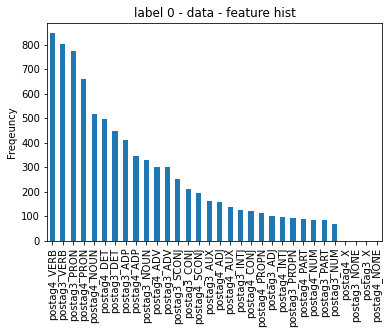

In [28]:
plot_hist(neg_df, 'label 0 - data - feature hist')